# Gated Ensemble: Landcover Model + GT Mangrove Labels on 0.5m Data

Run the landcover model on our private 0.5m mangrove dataset and combine
predictions with ground truth mangrove labels via a gated ensemble.

**Landcover Model**: SegFormer trained on Landcover.ai v1
- 5 output classes: Background, Building, Woodland, Water, Road

**Ground Truth Gate**: 0.5m mangrove dataset labels
- Binary: Not Mangrove (0), Mangrove (1), Ignore (255)

**Gated Ensemble Strategy**:
The landcover model cannot distinguish between woodland and mangrove — it labels
most mangrove pixels as "woodland". We use the GT mangrove labels as a gate:
wherever the ground truth is **mangrove**, we override the landcover prediction
with a dedicated **mangrove** class. This produces a 6-class output:

| Class | Label |
|-------|-------|
| 0 | Background |
| 1 | Building |
| 2 | Woodland |
| 3 | Water |
| 4 | Road |
| 5 | **Mangrove** (from GT) |

## 1. Setup and Configuration

In [14]:
import sys
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from tqdm import tqdm

# ============================================================
# CONFIGURATION
# ============================================================

# Paths
DATA_ROOT = Path('../data/0_5m')
WEIGHTS_DIR = Path('../weights')
PLOTS_DIR = Path('../plots/landcover_05m_inference')

# Data files
IMAGES_FILE = DATA_ROOT / '512dataset_images.npy'
LABELS_FILE = DATA_ROOT / '512dataset_labels.npy'

# --- Landcover model (5 classes) ---
MODEL_NAME = 'segformer'
LANDCOVER_WEIGHTS = WEIGHTS_DIR / 'human_segformer.pth'
LANDCOVER_NUM_CLASSES = 5

BATCH_SIZE = 16
NUM_WORKERS = 0
IGNORE_INDEX = 255

# Landcover class definitions (model output, 0-4)
LANDCOVER_NAMES = ['background', 'building', 'woodland', 'water', 'road']
LANDCOVER_COLORS = {
    0: [0.8, 0.8, 0.8],  # Background - gray
    1: [1.0, 0.0, 0.0],  # Building - red
    2: [0.0, 0.5, 0.0],  # Woodland - dark green
    3: [0.0, 0.0, 1.0],  # Water - blue
    4: [1.0, 1.0, 0.0],  # Road - yellow
}

# Ensemble output: 6 classes (landcover 0-4 + mangrove gate 5)
ENSEMBLE_NAMES = ['background', 'building', 'woodland', 'water', 'road', 'mangrove']
NUM_ENSEMBLE_CLASSES = 6
ENSEMBLE_COLORS = {
    0: [0.8, 0.8, 0.8],  # Background - gray
    1: [1.0, 0.0, 0.0],  # Building - red
    2: [0.0, 0.5, 0.0],  # Woodland - dark green
    3: [0.0, 0.0, 1.0],  # Water - blue
    4: [1.0, 1.0, 0.0],  # Road - yellow
    5: [0.0, 0.9, 0.4],  # Mangrove - bright green
}

# Mangrove GT legend
MANGROVE_NAMES = ['not_mangrove', 'mangrove']
MANGROVE_COLORS = {
    0: [0.8, 0.8, 0.8],
    1: [0.0, 0.7, 0.0],
}

PLOTS_DIR.mkdir(parents=True, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f"Landcover weights: {LANDCOVER_WEIGHTS}")
print(f"Target data: {DATA_ROOT}")

Device: cuda
Landcover weights: ..\weights\human_segformer.pth
Target data: ..\data\0_5m


## 2. Load Model

In [15]:
sys.path.insert(0, '../../')

from models import SegFormer

print("=== Loading Landcover Model (5-class) ===")
landcover_model = SegFormer(num_classes=LANDCOVER_NUM_CLASSES)
state_dict = torch.load(LANDCOVER_WEIGHTS, map_location=device)
landcover_model.load_state_dict(state_dict)
landcover_model = landcover_model.to(device)
landcover_model.eval()
print(f"Loaded: {LANDCOVER_WEIGHTS}")

=== Loading Landcover Model (5-class) ===


Loading weights: 100%|██████████| 364/364 [00:00<00:00, 1174.38it/s, Materializing param=encoder.patch_embeddings.3.proj.weight]            
SegformerModel LOAD REPORT from: nvidia/segformer-b2-finetuned-ade-512-512
Key                                           | Status     |  | 
----------------------------------------------+------------+--+-
decode_head.batch_norm.num_batches_tracked    | UNEXPECTED |  | 
decode_head.linear_fuse.weight                | UNEXPECTED |  | 
decode_head.linear_c.{0, 1, 2, 3}.proj.weight | UNEXPECTED |  | 
decode_head.linear_c.{0, 1, 2, 3}.proj.bias   | UNEXPECTED |  | 
decode_head.classifier.bias                   | UNEXPECTED |  | 
decode_head.batch_norm.bias                   | UNEXPECTED |  | 
decode_head.classifier.weight                 | UNEXPECTED |  | 
decode_head.batch_norm.running_var            | UNEXPECTED |  | 
decode_head.batch_norm.weight                 | UNEXPECTED |  | 
decode_head.batch_norm.running_mean           | UNEXPECTED |  | 

Not

Loaded: ..\weights\human_segformer.pth


## 3. Load Mangrove Dataset

In [16]:
class MangroveDataset(Dataset):
    """Load 0.5m mangrove .npy data for inference."""
    
    MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    STD = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __init__(self, images_path, labels_path, indices=None):
        self.images = np.load(images_path, mmap_mode='r')
        self.labels = np.load(labels_path, mmap_mode='r')
        self.indices = indices if indices is not None else np.arange(len(self.images))
        print(f"Loaded {len(self.indices)} samples")
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        
        image = self.images[real_idx].copy()
        label = self.labels[real_idx].copy()
        
        image = torch.from_numpy(image).float()
        if image.max() > 1.5:
            image = image / 255.0
        image = (image - self.MEAN) / self.STD
        
        label = torch.from_numpy(label).long()
        if label.dim() == 3:
            label = label.squeeze(0)
        
        return image, label, real_idx


print("=== Loading Mangrove Dataset ===")
print()

# Load all samples
dataset = MangroveDataset(IMAGES_FILE, LABELS_FILE)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\nTotal samples: {len(dataset):,}")
print(f"Batches: {len(loader):,}")

=== Loading Mangrove Dataset ===

Loaded 573 samples

Total samples: 573
Batches: 36


## 4. Run Gated Ensemble Inference

In [17]:
print("=== Running Gated Ensemble Inference ===")
print()

all_landcover_preds = []
all_targets = []

with torch.no_grad():
    for images, masks, _ in tqdm(loader, desc="Inference"):
        images = images.to(device)

        # Landcover model: 5-class argmax
        lc_out = landcover_model(images)
        lc_preds = torch.argmax(lc_out, dim=1)

        all_landcover_preds.append(lc_preds.cpu().numpy())
        all_targets.append(masks.numpy())

all_landcover_preds = np.concatenate(all_landcover_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# --- Apply gated ensemble ---
# Start with landcover predictions (classes 0-4)
# Where GT label is mangrove -> override with class 5
all_ensemble_preds = all_landcover_preds.copy()
mangrove_gate = all_targets == 1
all_ensemble_preds[mangrove_gate] = 5

torch.cuda.empty_cache()

print(f"\nLandcover preds shape: {all_landcover_preds.shape}")
print(f"Targets shape:         {all_targets.shape}")
print(f"Ensemble preds shape:  {all_ensemble_preds.shape}")
print(f"Ensemble classes present: {np.unique(all_ensemble_preds).tolist()}")
print(f"Pixels gated to mangrove (GT): {mangrove_gate.sum():,} ({mangrove_gate.mean()*100:.1f}%)")

=== Running Gated Ensemble Inference ===



Inference: 100%|██████████| 36/36 [13:32<00:00, 22.56s/it]



Landcover preds shape: (573, 512, 512)
Targets shape:         (573, 512, 512)
Ensemble preds shape:  (573, 512, 512)
Ensemble classes present: [0, 1, 2, 3, 4, 5]
Pixels gated to mangrove (GT): 40,731,534 (27.1%)


## 5. Ensemble Class Distribution Analysis

What does the gated ensemble predict across the dataset?

In [18]:
print("=== Ensemble Prediction Distribution ===")
print()

preds_flat = all_ensemble_preds.flatten()
targets_flat = all_targets.flatten()

total_pixels = len(preds_flat)
print(f"Total pixels: {total_pixels:,}")
print()
print("Ensemble prediction distribution:")
print(f"{'Class':<12} {'Count':>12} {'Percentage':>10}")
print("-" * 36)

pred_counts = {}
for c in range(NUM_ENSEMBLE_CLASSES):
    count = (preds_flat == c).sum()
    pct = count / total_pixels * 100
    pred_counts[c] = count
    print(f"{ENSEMBLE_NAMES[c]:<12} {count:>12,} {pct:>9.1f}%")

=== Ensemble Prediction Distribution ===

Total pixels: 150,208,512

Ensemble prediction distribution:
Class               Count Percentage
------------------------------------
background     61,520,244      41.0%
building        2,430,988       1.6%
woodland       16,186,315      10.8%
water          27,627,356      18.4%
road            1,712,075       1.1%
mangrove       40,731,534      27.1%


In [19]:
# Breakdown: what does the ensemble predict for mangrove vs non-mangrove pixels?
print("=== Ensemble Predictions Conditioned on Ground Truth ===")
print()

for gt_class, gt_name in enumerate(MANGROVE_NAMES):
    mask = targets_flat == gt_class
    if mask.sum() == 0:
        continue

    gt_preds = preds_flat[mask]
    gt_total = len(gt_preds)

    print(f"Where ground truth = {gt_name} ({gt_total:,} pixels):")
    for c in range(NUM_ENSEMBLE_CLASSES):
        count = (gt_preds == c).sum()
        pct = count / gt_total * 100
        bar = '#' * int(pct / 2)
        print(f"  -> {ENSEMBLE_NAMES[c]:<12}: {pct:>5.1f}%  {bar}")
    print()

# Also show ignore pixels
ignore_mask = targets_flat == IGNORE_INDEX
if ignore_mask.sum() > 0:
    ignore_preds = preds_flat[ignore_mask]
    ignore_total = len(ignore_preds)
    print(f"Where ground truth = ignore/255 ({ignore_total:,} pixels):")
    for c in range(NUM_ENSEMBLE_CLASSES):
        count = (ignore_preds == c).sum()
        pct = count / ignore_total * 100
        print(f"  -> {ENSEMBLE_NAMES[c]:<12}: {pct:>5.1f}%")

=== Ensemble Predictions Conditioned on Ground Truth ===

Where ground truth = not_mangrove (68,394,240 pixels):
  -> background  :  43.8%  #####################
  -> building    :   0.6%  
  -> woodland    :  23.5%  ###########
  -> water       :  30.2%  ###############
  -> road        :   1.9%  
  -> mangrove    :   0.0%  

Where ground truth = mangrove (40,731,534 pixels):
  -> background  :   0.0%  
  -> building    :   0.0%  
  -> woodland    :   0.0%  
  -> water       :   0.0%  
  -> road        :   0.0%  
  -> mangrove    : 100.0%  ##################################################

Where ground truth = ignore/255 (41,082,738 pixels):
  -> background  :  76.9%
  -> building    :   4.9%
  -> woodland    :   0.2%
  -> water       :  16.9%
  -> road        :   1.0%
  -> mangrove    :   0.0%


=== Plotting Ensemble Distribution ===



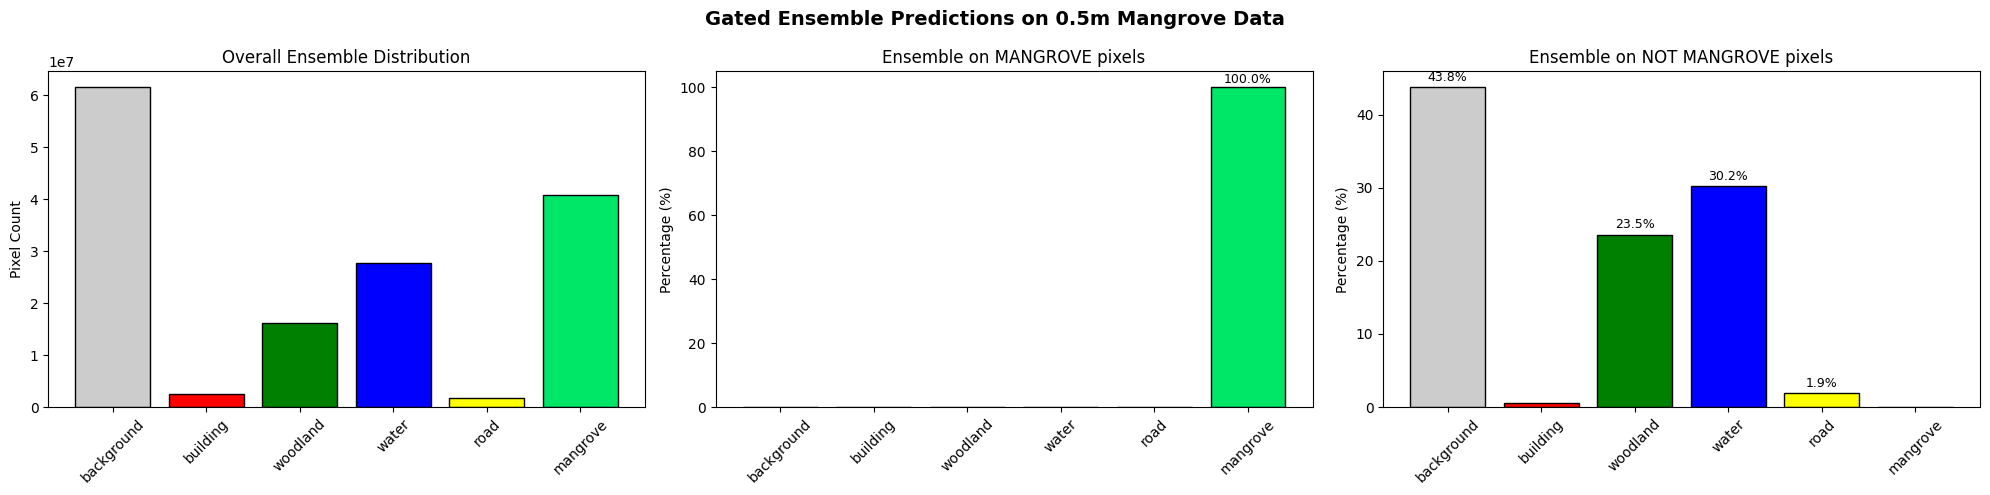

Saved: ..\plots\landcover_05m_inference\ensemble_distribution.png


In [20]:
print("=== Plotting Ensemble Distribution ===")
print()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Gated Ensemble Predictions on 0.5m Mangrove Data', fontsize=14, fontweight='bold')

colors = [ENSEMBLE_COLORS[i] for i in range(NUM_ENSEMBLE_CLASSES)]

# 1. Overall
counts = [pred_counts[c] for c in range(NUM_ENSEMBLE_CLASSES)]
axes[0].bar(ENSEMBLE_NAMES, counts, color=colors, edgecolor='black')
axes[0].set_title('Overall Ensemble Distribution')
axes[0].set_ylabel('Pixel Count')
axes[0].tick_params(axis='x', rotation=45)

# 2. Predictions where GT = mangrove
mangrove_mask = targets_flat == 1
if mangrove_mask.sum() > 0:
    mangrove_preds_cond = preds_flat[mangrove_mask]
    m_pcts = [(mangrove_preds_cond == c).sum() / len(mangrove_preds_cond) * 100 for c in range(NUM_ENSEMBLE_CLASSES)]
    bars = axes[1].bar(ENSEMBLE_NAMES, m_pcts, color=colors, edgecolor='black')
    for bar, pct in zip(bars, m_pcts):
        if pct > 1:
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[1].set_title('Ensemble on MANGROVE pixels')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].tick_params(axis='x', rotation=45)

# 3. Predictions where GT = not_mangrove
nonmangrove_mask = targets_flat == 0
if nonmangrove_mask.sum() > 0:
    nm_preds = preds_flat[nonmangrove_mask]
    nm_pcts = [(nm_preds == c).sum() / len(nm_preds) * 100 for c in range(NUM_ENSEMBLE_CLASSES)]
    bars = axes[2].bar(ENSEMBLE_NAMES, nm_pcts, color=colors, edgecolor='black')
    for bar, pct in zip(bars, nm_pcts):
        if pct > 1:
            axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[2].set_title('Ensemble on NOT MANGROVE pixels')
    axes[2].set_ylabel('Percentage (%)')
    axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'ensemble_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {PLOTS_DIR / 'ensemble_distribution.png'}")

## 6. Visualize Predictions

In [21]:
def denormalize(img):
    """Reverse ImageNet normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return torch.clamp(img * std + mean, 0, 1)


def mask_to_rgb(mask, class_colors, ignore_index=None):
    """Convert class mask to RGB."""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3))
    for class_id, color in class_colors.items():
        rgb[mask == class_id] = color
    if ignore_index is not None:
        rgb[mask == ignore_index] = [1.0, 1.0, 1.0]  # White for ignore
    return rgb


print("Visualization functions defined")

Visualization functions defined


=== Grid Visualization ===



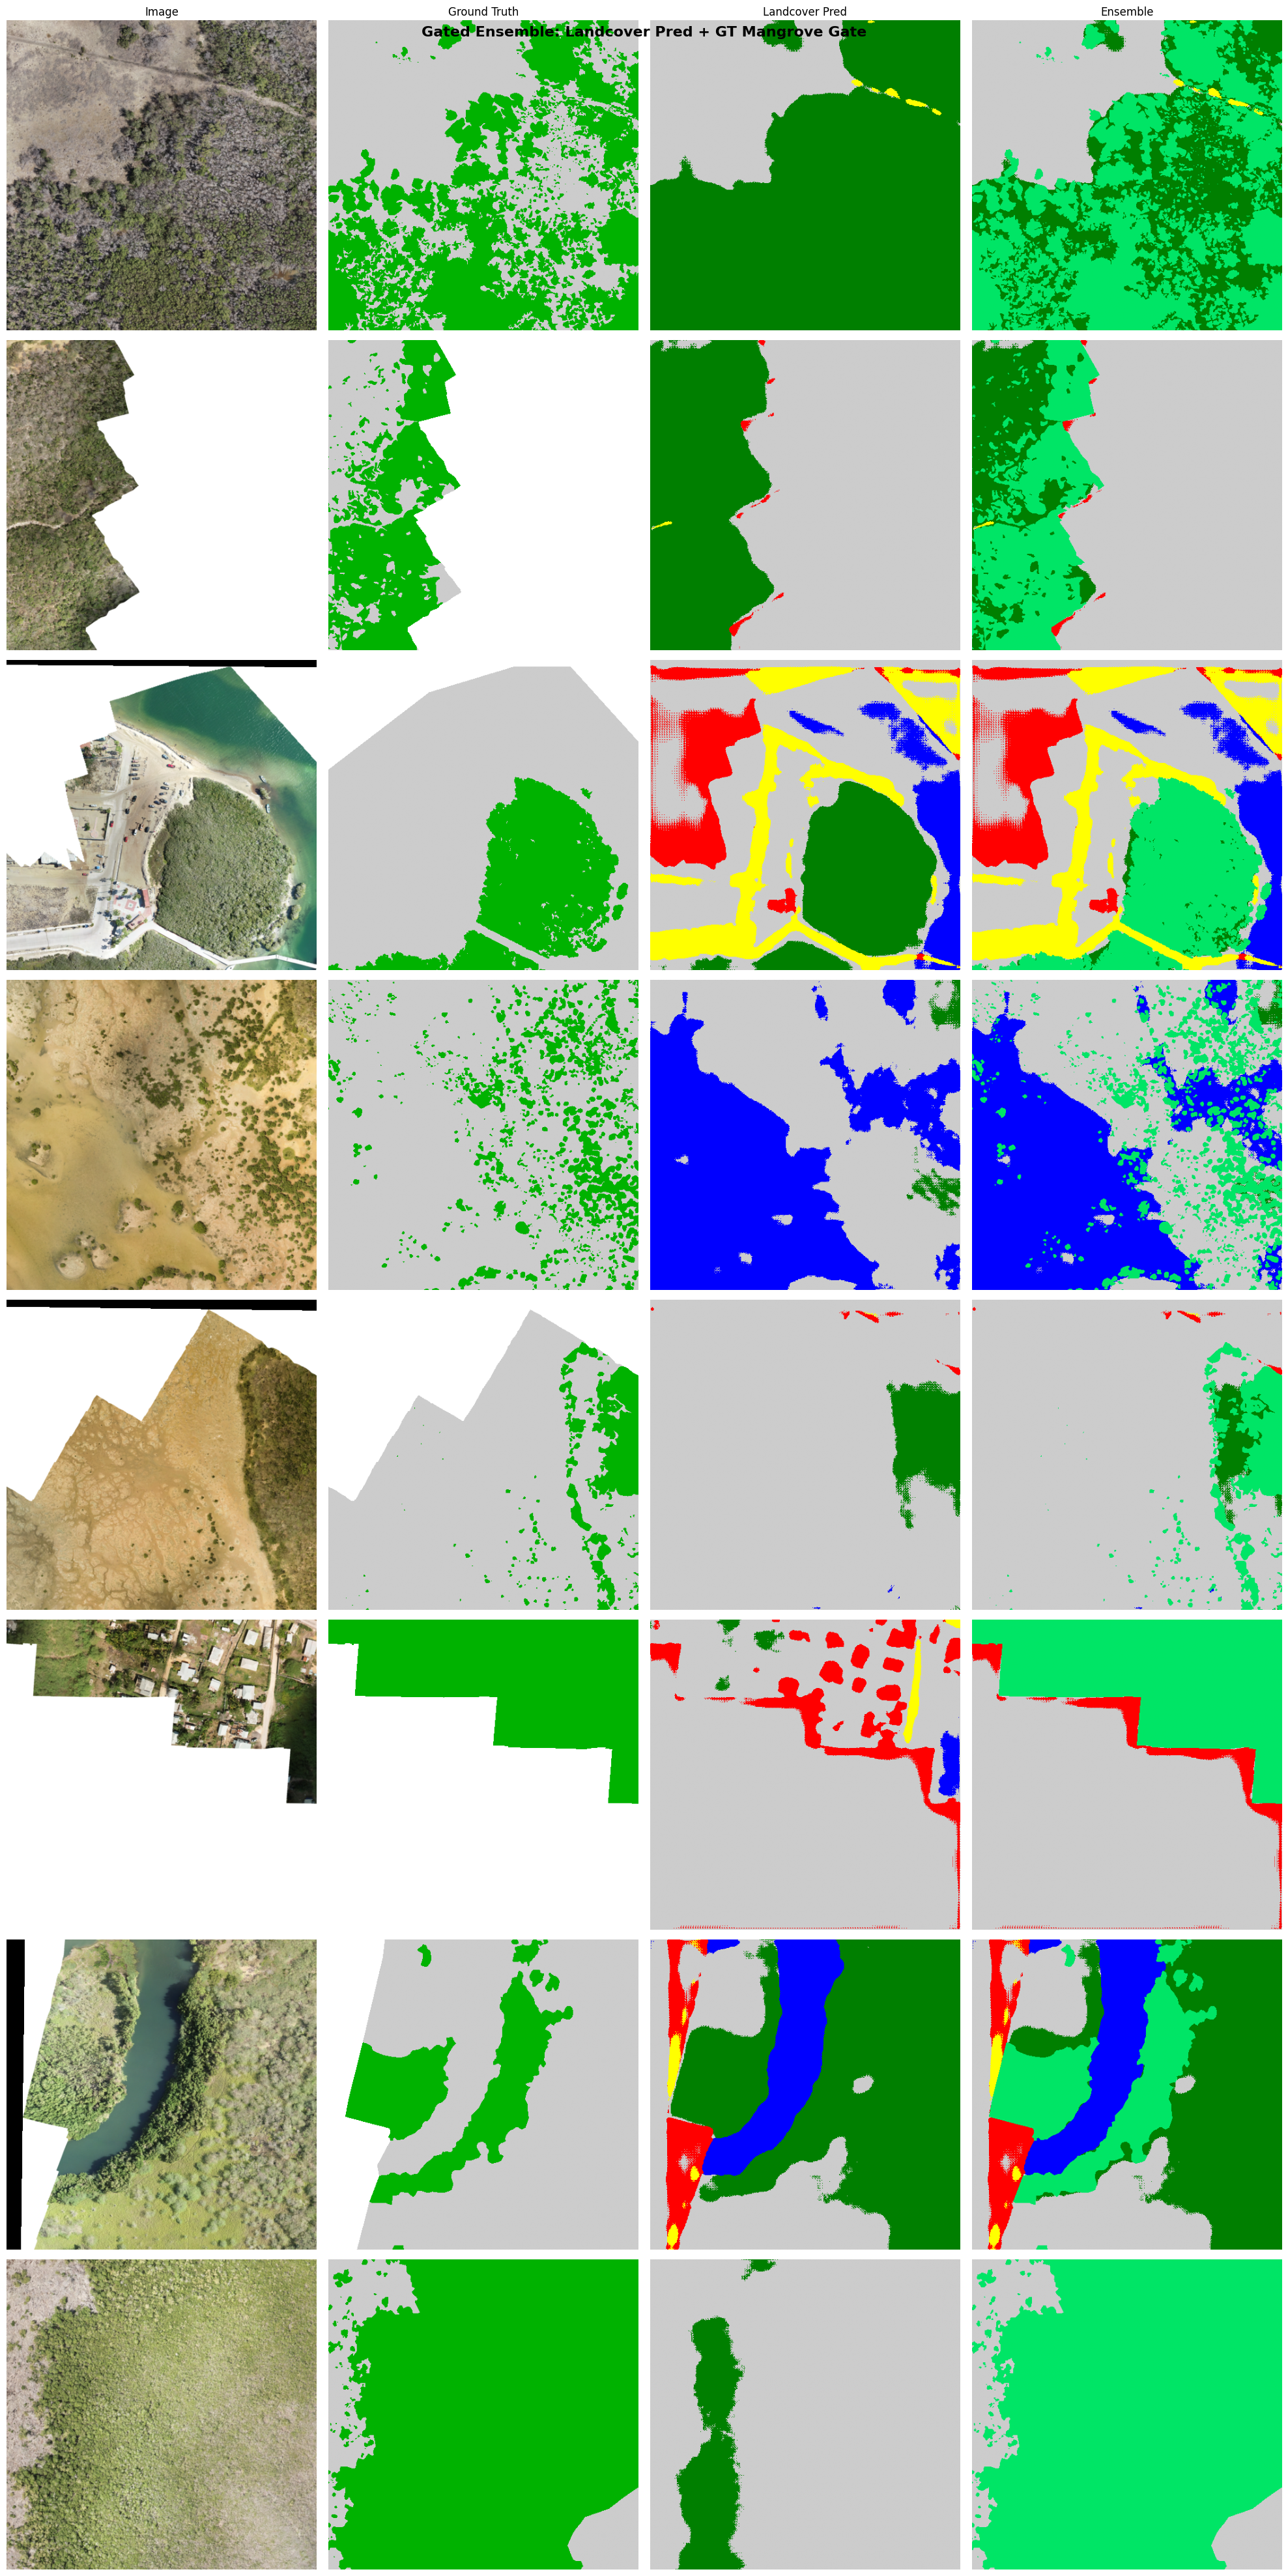

Saved: ..\plots\landcover_05m_inference\ensemble_grid.png


In [22]:
print("=== Grid Visualization ===")
print()

n_samples = 8
np.random.seed(67)
sample_indices = np.random.choice(len(dataset), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5 * n_samples))
fig.suptitle('Gated Ensemble: Landcover Pred + GT Mangrove Gate', fontsize=16, fontweight='bold')

col_titles = ['Image', 'Ground Truth', 'Landcover Pred', 'Ensemble']

torch.cuda.empty_cache()

with torch.no_grad():
    for row, idx in enumerate(sample_indices):
        img, mask, real_idx = dataset[idx]
        img_dev = img.unsqueeze(0).to(device)

        lc_pred = torch.argmax(landcover_model(img_dev), dim=1).squeeze().cpu().numpy()

        # Ensemble: landcover base, GT mangrove overrides to class 5
        mask_np = mask.numpy()
        ens_pred = lc_pred.copy()
        ens_pred[mask_np == 1] = 5

        img_np = denormalize(img).numpy().transpose(1, 2, 0)

        # Image
        axes[row, 0].imshow(img_np)
        axes[row, 0].set_ylabel(f'idx={real_idx}', fontsize=10)
        axes[row, 0].axis('off')

        # Ground truth (binary)
        axes[row, 1].imshow(mask_to_rgb(mask_np, MANGROVE_COLORS, IGNORE_INDEX))
        axes[row, 1].axis('off')

        # Landcover prediction (5-class)
        axes[row, 2].imshow(mask_to_rgb(lc_pred, LANDCOVER_COLORS))
        axes[row, 2].axis('off')

        # Ensemble (6-class)
        axes[row, 3].imshow(mask_to_rgb(ens_pred, ENSEMBLE_COLORS))
        axes[row, 3].axis('off')

        if row == 0:
            for col, title in enumerate(col_titles):
                axes[row, col].set_title(title, fontsize=12)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'ensemble_grid.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {PLOTS_DIR / 'ensemble_grid.png'}")

## 7. Per-Sample Inspection

Pick specific indices to examine in detail.

In [23]:
def inspect_sample(landcover_model, dataset, idx):
    """Detailed inspection of a single sample with GT-gated ensemble."""
    torch.cuda.empty_cache()

    img, mask, real_idx = dataset[idx]

    with torch.no_grad():
        img_dev = img.unsqueeze(0).to(device)
        lc_pred = torch.argmax(landcover_model(img_dev), dim=1).squeeze().cpu().numpy()

    mask_np = mask.numpy()
    ens_pred = lc_pred.copy()
    ens_pred[mask_np == 1] = 5

    img_np = denormalize(img).numpy().transpose(1, 2, 0)

    valid = mask_np != IGNORE_INDEX
    total_valid = valid.sum()

    print(f"Sample {real_idx}:")
    print(f"  GT mangrove: {(mask_np == 1).sum() / total_valid * 100:.1f}%")
    print(f"  Ensemble predictions:")
    for c in range(NUM_ENSEMBLE_CLASSES):
        pct = (ens_pred[valid] == c).sum() / total_valid * 100
        print(f"    {ENSEMBLE_NAMES[c]:<12}: {pct:>5.1f}%")

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Sample {real_idx}', fontsize=14)

    axes[0].imshow(img_np)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask_to_rgb(mask_np, MANGROVE_COLORS, IGNORE_INDEX))
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(mask_to_rgb(lc_pred, LANDCOVER_COLORS))
    axes[2].set_title('Landcover Pred')
    axes[2].axis('off')

    axes[3].imshow(mask_to_rgb(ens_pred, ENSEMBLE_COLORS))
    axes[3].set_title('Ensemble')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()


print("inspect_sample() defined")
print("Usage: inspect_sample(landcover_model, dataset, idx=0)")

inspect_sample() defined
Usage: inspect_sample(landcover_model, dataset, idx=0)


Sample 0:
  GT mangrove: 39.2%
  Ensemble predictions:
    background  :  49.6%
    building    :   0.2%
    woodland    :   1.8%
    water       :   9.0%
    road        :   0.2%
    mangrove    :  39.2%


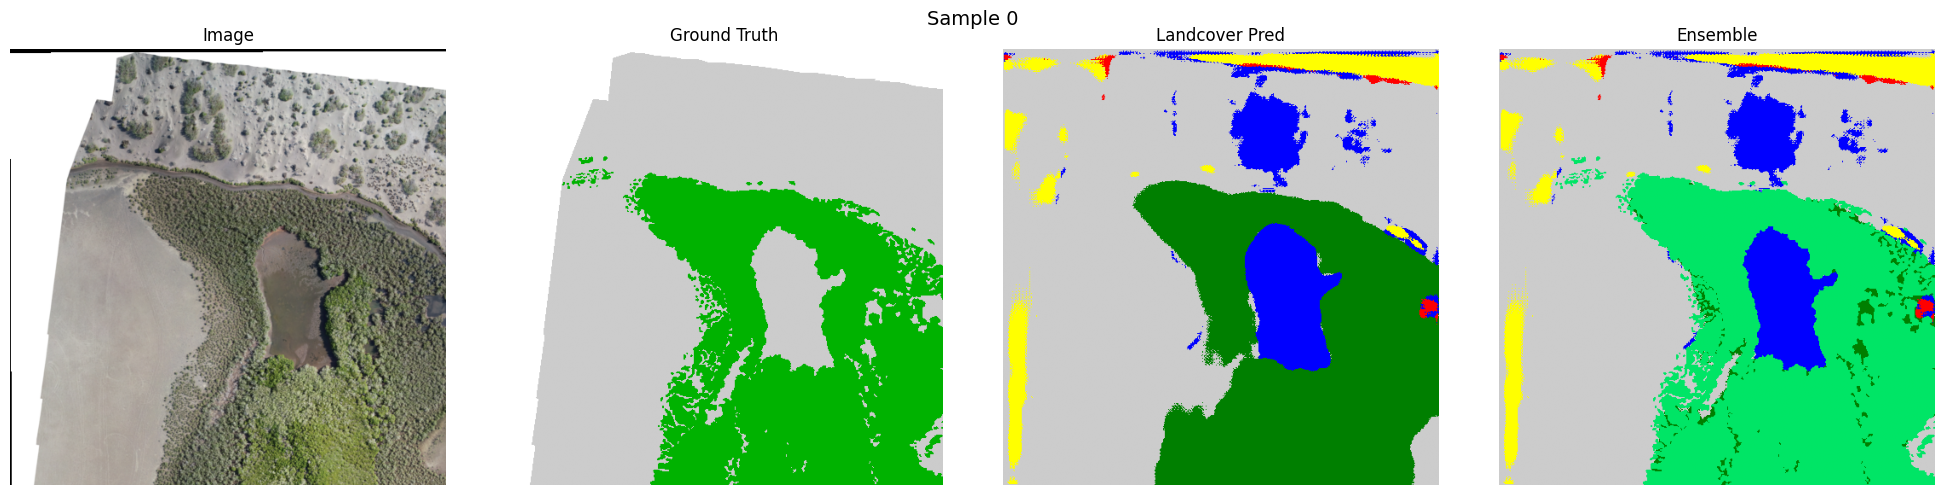

Sample 100:
  GT mangrove: 38.7%
  Ensemble predictions:
    background  :  14.8%
    building    :   0.0%
    woodland    :   0.0%
    water       :  46.3%
    road        :   0.2%
    mangrove    :  38.7%


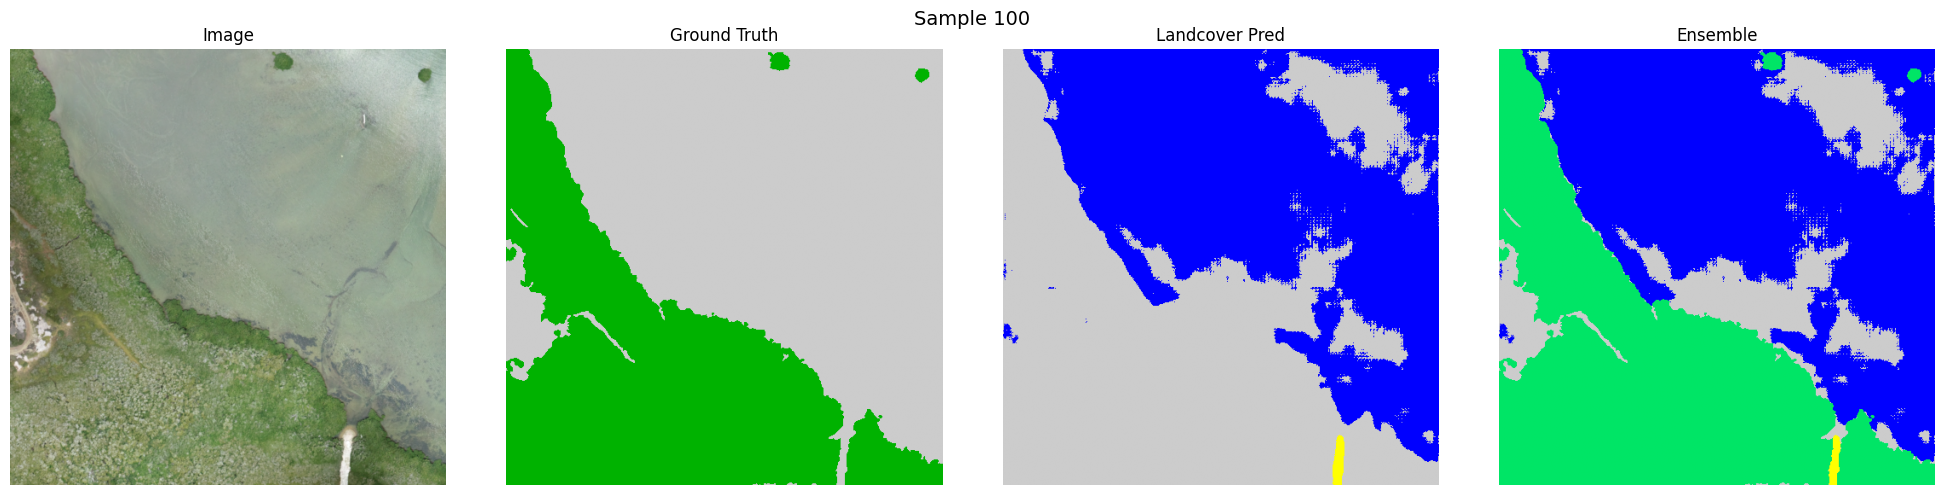

Sample 200:
  GT mangrove: 56.2%
  Ensemble predictions:
    background  :  12.1%
    building    :   0.0%
    woodland    :   2.8%
    water       :  26.8%
    road        :   2.1%
    mangrove    :  56.2%


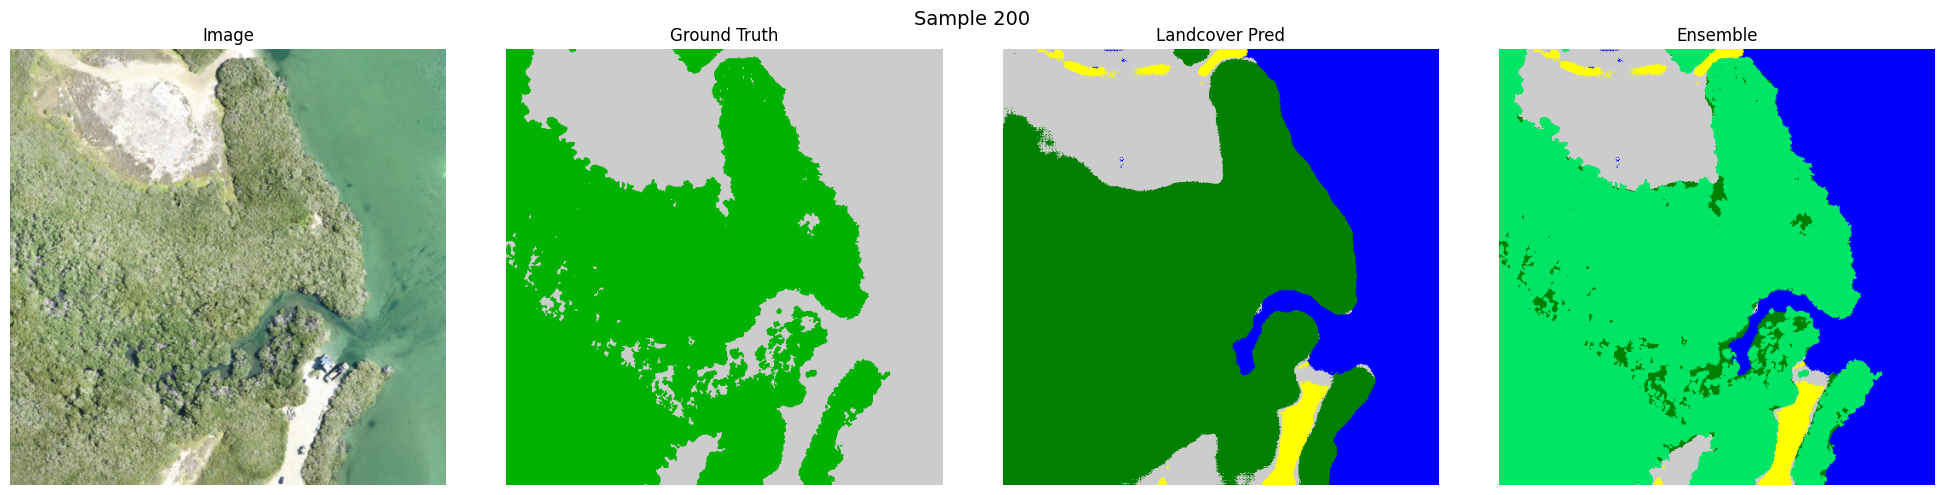

In [24]:
# Inspect specific samples
inspect_sample(landcover_model, dataset, 0)
inspect_sample(landcover_model, dataset, 100)
inspect_sample(landcover_model, dataset, 200)

## 8. Save Results

In [25]:
print("=== Saving Results ===")
print()

valid_mask = targets_flat != IGNORE_INDEX
valid_preds = preds_flat[valid_mask]
valid_targets = targets_flat[valid_mask]

overall_dist = {}
for c in range(NUM_ENSEMBLE_CLASSES):
    overall_dist[ENSEMBLE_NAMES[c]] = float((valid_preds == c).sum() / len(valid_preds))

mangrove_dist = {}
nonmangrove_dist = {}
for c in range(NUM_ENSEMBLE_CLASSES):
    m_mask = valid_targets == 1
    nm_mask = valid_targets == 0
    if m_mask.sum() > 0:
        mangrove_dist[ENSEMBLE_NAMES[c]] = float((valid_preds[m_mask] == c).sum() / m_mask.sum())
    if nm_mask.sum() > 0:
        nonmangrove_dist[ENSEMBLE_NAMES[c]] = float((valid_preds[nm_mask] == c).sum() / nm_mask.sum())

results = {
    'method': 'gated_ensemble_gt',
    'landcover_model': str(LANDCOVER_WEIGHTS),
    'gate': 'ground_truth_labels',
    'num_samples': len(dataset),
    'ensemble_classes': ENSEMBLE_NAMES,
    'overall_prediction_distribution': overall_dist,
    'predictions_on_mangrove_pixels': mangrove_dist,
    'predictions_on_non_mangrove_pixels': nonmangrove_dist,
    'pixels_gated_to_mangrove': int(mangrove_gate.sum()),
    'gate_percentage': float(mangrove_gate.mean() * 100),
}

results_file = PLOTS_DIR / 'ensemble_results.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Saved: {results_file}")
print()
print("All outputs:")
print(f"  {PLOTS_DIR / 'ensemble_distribution.png'}")
print(f"  {PLOTS_DIR / 'ensemble_grid.png'}")
print(f"  {PLOTS_DIR / 'ensemble_results.json'}")

=== Saving Results ===

Saved: ..\plots\landcover_05m_inference\ensemble_results.json

All outputs:
  ..\plots\landcover_05m_inference\ensemble_distribution.png
  ..\plots\landcover_05m_inference\ensemble_grid.png
  ..\plots\landcover_05m_inference\ensemble_results.json


## 9. Legend

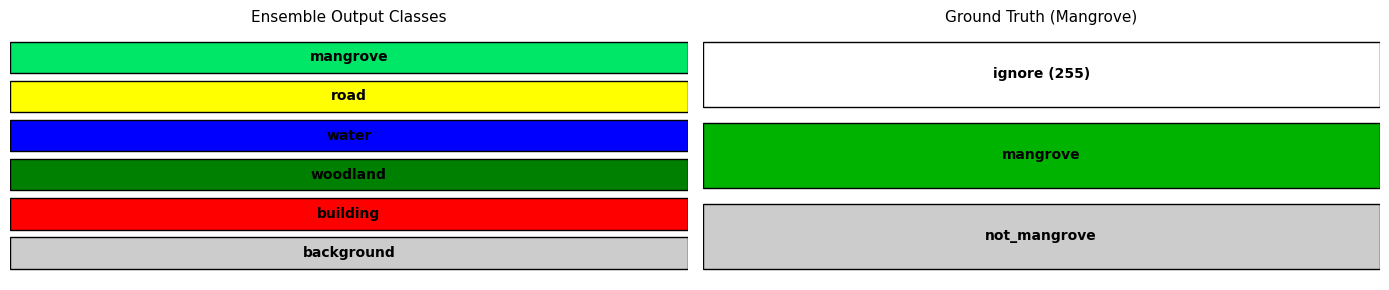

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3))

# Ensemble legend (6 classes)
for i, (name, color) in enumerate(zip(ENSEMBLE_NAMES, [ENSEMBLE_COLORS[c] for c in range(NUM_ENSEMBLE_CLASSES)])):
    axes[0].barh(i, 1, color=color, edgecolor='black')
    axes[0].text(0.5, i, name, ha='center', va='center', fontsize=10, fontweight='bold')
axes[0].set_title('Ensemble Output Classes', fontsize=11)
axes[0].set_xlim(0, 1)
axes[0].axis('off')

# GT legend
for i, (name, color) in enumerate(zip(MANGROVE_NAMES, [MANGROVE_COLORS[c] for c in range(2)])):
    axes[1].barh(i, 1, color=color, edgecolor='black')
    axes[1].text(0.5, i, name, ha='center', va='center', fontsize=10, fontweight='bold')
axes[1].barh(2, 1, color=[1, 1, 1], edgecolor='black')
axes[1].text(0.5, 2, 'ignore (255)', ha='center', va='center', fontsize=10, fontweight='bold')
axes[1].set_title('Ground Truth (Mangrove)', fontsize=11)
axes[1].set_xlim(0, 1)
axes[1].axis('off')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'ensemble_legend.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Export to CVAT for Label Refinement

Save ensemble predictions in **CVAT Segmentation Mask 1.1** format so we can
import them into CVAT, review, and refine the labels.

Outputs:
- `cvat_export/images/` — tile images (upload as CVAT task images)
- `cvat_export/cvat_ensemble_masks.zip` — annotation ZIP (import into CVAT)

In [27]:
import os
import zipfile
import tempfile
from PIL import Image as PILImage

# ============================================================
# CVAT Export Configuration
# ============================================================

CVAT_EXPORT_DIR = DATA_ROOT / 'cvat_export'
CVAT_IMAGES_DIR = CVAT_EXPORT_DIR / 'images'
CVAT_ZIP_PATH = CVAT_EXPORT_DIR / 'cvat_ensemble_masks.zip'

# CVAT labelmap colors (RGB uint8) for 6 ensemble classes
CVAT_CLASS_COLORS = {
    0: (204, 204, 204),   # background - gray
    1: (255, 0, 0),       # building - red
    2: (0, 128, 0),       # woodland - dark green
    3: (0, 0, 255),       # water - blue
    4: (255, 255, 0),     # road - yellow
    5: (0, 230, 102),     # mangrove - bright green
}

CVAT_EXPORT_DIR.mkdir(parents=True, exist_ok=True)
CVAT_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================
# Step 1: Save tile images as PNGs (for CVAT task upload)
# ============================================================
print("=== Saving tile images ===")

raw_images = np.load(IMAGES_FILE, mmap_mode='r')

for i in tqdm(range(len(dataset)), desc="Saving images"):
    real_idx = dataset.indices[i]
    img = raw_images[real_idx]
    
    # Ensure uint8
    if img.max() <= 1.5:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    
    # Handle channel-first format (C, H, W) -> (H, W, C)
    if img.shape[0] == 3 and img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    
    PILImage.fromarray(img).save(CVAT_IMAGES_DIR / f'tile_{real_idx:05d}.png')

print(f"Saved {len(dataset)} images to {CVAT_IMAGES_DIR}")

# ============================================================
# Step 2: Create CVAT Segmentation Mask 1.1 ZIP
# ============================================================
print("\n=== Creating CVAT annotation ZIP ===")

with tempfile.TemporaryDirectory() as tmp:
    tmp_path = Path(tmp)
    
    seg_class_dir = tmp_path / "SegmentationClass"
    seg_obj_dir = tmp_path / "SegmentationObject"
    imageset_dir = tmp_path / "ImageSets" / "Segmentation"
    
    seg_class_dir.mkdir(parents=True)
    seg_obj_dir.mkdir(parents=True)
    imageset_dir.mkdir(parents=True)
    
    # --- labelmap.txt ---
    with open(tmp_path / "labelmap.txt", 'w') as f:
        for class_id, class_name in enumerate(ENSEMBLE_NAMES):
            r, g, b = CVAT_CLASS_COLORS[class_id]
            f.write(f"{class_name}:{r},{g},{b}::\n")
    
    # --- Save masks + build image list ---
    image_names = []
    for i in tqdm(range(len(dataset)), desc="Saving masks"):
        real_idx = dataset.indices[i]
        name = f'tile_{real_idx:05d}'
        image_names.append(name)
        
        mask = all_ensemble_preds[i].astype(np.uint8)
        PILImage.fromarray(mask).save(seg_class_dir / f'{name}.png')
        PILImage.fromarray(mask).save(seg_obj_dir / f'{name}.png')
    
    # --- ImageSets/Segmentation/default.txt ---
    with open(imageset_dir / "default.txt", 'w') as f:
        for name in image_names:
            f.write(name + '\n')
    
    # --- Create ZIP ---
    with zipfile.ZipFile(CVAT_ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, dirs, files in os.walk(tmp_path):
            for file in files:
                file_path = Path(root) / file
                arcname = file_path.relative_to(tmp_path)
                zf.write(file_path, arcname)

zip_size_mb = CVAT_ZIP_PATH.stat().st_size / (1024**2)
print(f"\nCVAT export complete!")
print(f"  Images: {CVAT_IMAGES_DIR}  ({len(dataset)} PNGs)")
print(f"  Annotations: {CVAT_ZIP_PATH}  ({zip_size_mb:.1f} MB)")
print(f"  Classes: {ENSEMBLE_NAMES}")

=== Saving tile images ===


Saving images: 100%|██████████| 573/573 [00:11<00:00, 50.84it/s]


Saved 573 images to ..\data\0_5m\cvat_export\images

=== Creating CVAT annotation ZIP ===


Saving masks: 100%|██████████| 573/573 [00:03<00:00, 185.85it/s]



CVAT export complete!
  Images: ..\data\0_5m\cvat_export\images  (573 PNGs)
  Annotations: ..\data\0_5m\cvat_export\cvat_ensemble_masks.zip  (8.1 MB)
  Classes: ['background', 'building', 'woodland', 'water', 'road', 'mangrove']


### How to import into CVAT

1. **Create a CVAT project** with these labels (must match exactly):
   - `background`, `building`, `woodland`, `water`, `road`, `mangrove`

2. **Create a task** and upload the images from `cvat_export/images/`

3. **Import annotations**: Menu → Upload annotations → **Segmentation mask 1.1** → upload `cvat_export/cvat_ensemble_masks.zip`

4. **Refine labels** using the brush/eraser tools, then export corrected masks